In [1]:
import utils.cs_vqe_tools as c_tools
import utils.qonversion_tools as qonvert
import utils.bit_tools as bit
import utils.circuit_tools as circ
import utils.linalg_tools as la
import utils.plotting_tools as plot
from utils.UCCSD_ansatz import Get_UCCSD_ia_terms, Get_UCCSD_ijab_terms, Fermi_ops_to_qubit_ops

import cs_vqe_classes.cs_vqe as c
import cs_vqe_classes.eigenstate as eig
import cs_vqe_classes.cs_vqe_circuit as cs_circ

import ast
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
from openfermion.linalg import LinearQubitOperator, get_sparse_operator, get_ground_state
import itertools
from statistics import median

from qiskit.circuit.parameter import Parameter
from qiskit.circuit.quantumcircuit import QuantumCircuit, QuantumRegister
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.aqua.components.optimizers import SLSQP, COBYLA
from qiskit.algorithms import VQE
from qiskit import Aer

import cirq

from qiskit.providers.aer import AerError

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/optimizer.py:50: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit.algorithms.optimizers', 'qiskit-terra')


In [2]:
import openfermion
import openfermionpyscf
from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.transforms import get_fermion_operator
from openfermion.circuits import (uccsd_singlet_get_packed_amplitudes,
                               uccsd_singlet_generator, uccsd_generator,
                               uccsd_convert_amplitude_format)

singlet_bool = True # Set general UCCSD or singlet UCCSD.

bond_len = 0.772#1.45
atom_1 = 'H'
atom_2 = 'H'
atom_3 = 'H'
basis = 'sto-3g'
multiplicity = 1
charge = 1

coordinate_1 = (0.0, 0.0, 0.0)
coordinate_2 = (0.0, 0.0, bond_len)
coordinate_3 = (0.0, bond_len, 0.0)

geometry = [(atom_1, coordinate_1), (atom_2, coordinate_2), (atom_3, coordinate_3)]

molecule_data = MolecularData(geometry, basis, multiplicity, charge, description='Test')
#molecule.load()

# Set calculation parameters.
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1
delete_input = True
delete_output = True

# Run pyscf.
molecule = run_pyscf(molecule_data,
                     run_scf=run_scf,
                     run_mp2=run_mp2,
                     run_cisd=run_cisd,
                     run_ccsd=run_ccsd,
                     run_fci=run_fci)

#molecule.load()
#print(molecule)

ham_f = get_fermion_operator(molecule.get_molecular_hamiltonian())
ham_q = jordan_wigner(ham_f)
print('Hamiltonian:', '\n', ham_q, '\n')

scf = True      # Hartree-Fock.
mp2 = True      # Moller-Plesset 2.
cisd = True     # Configuration interaction singles and doubles.
ccsd = True     # Coupled cluster singles and doubles.
fci = True      # Full configuration interaction.

calculated_molecule = run_pyscf(molecule_data, scf, mp2, cisd, ccsd, fci)

if ccsd:
    ccsd_single_amps = calculated_molecule.ccsd_single_amps
    ccsd_double_amps = calculated_molecule.ccsd_double_amps

num_electrons = calculated_molecule.n_electrons
num_qubits = 2*calculated_molecule.n_orbitals

if singlet_bool:
    # Get singlet UCCSD generator.
    packed_amps = uccsd_singlet_get_packed_amplitudes(ccsd_single_amps,  ccsd_double_amps, num_qubits, num_electrons)
    ucc_op = uccsd_singlet_generator(packed_amps, num_qubits, num_electrons)
    #print(ucc_sing)

else:
    # Get general UCCSD operator.
    ucc_op = uccsd_generator(ccsd_single_amps, ccsd_double_amps)
    #print(ucc_op)
    
ucc_q = jordan_wigner(ucc_op)
ucc = qonvert.QubitOperator_to_dict(ucc_q, num_qubits)
print('UCCSD ansatz:', '\n', ucc_q)

Hamiltonian: 
 (-0.017210915659800333+0j) [] +
(-0.036089282737986006+0j) [X0 X1 Y2 Y3] +
(-0.034934999375448306+0j) [X0 X1 Y4 Y5] +
(0.036089282737986006+0j) [X0 Y1 Y2 X3] +
(0.034934999375448306+0j) [X0 Y1 Y4 X5] +
(-0.026365874906949322+0j) [X0 Z1 X2 X3 Z4 X5] +
(-0.026365874906949322+0j) [X0 Z1 X2 Y3 Z4 Y5] +
(0.00922106569069939+0j) [X0 Z1 Z2 Z3 X4] +
(-0.023828207722769775+0j) [X0 Z1 Z2 Z3 X4 Z5] +
(0.014536731246500907+0j) [X0 Z1 Z2 X4] +
(-0.011829143660448417+0j) [X0 Z1 Z3 X4] +
(-0.011899632382875806+0j) [X0 Z2 Z3 X4] +
(0.036089282737986006+0j) [Y0 X1 X2 Y3] +
(0.034934999375448306+0j) [Y0 X1 X4 Y5] +
(-0.036089282737986006+0j) [Y0 Y1 X2 X3] +
(-0.034934999375448306+0j) [Y0 Y1 X4 X5] +
(-0.026365874906949322+0j) [Y0 Z1 Y2 X3 Z4 X5] +
(-0.026365874906949322+0j) [Y0 Z1 Y2 Y3 Z4 Y5] +
(0.00922106569069939+0j) [Y0 Z1 Z2 Z3 Y4] +
(-0.023828207722769775+0j) [Y0 Z1 Z2 Z3 Y4 Z5] +
(0.014536731246500907+0j) [Y0 Z1 Z2 Y4] +
(-0.011829143660448417+0j) [Y0 Z1 Z3 Y4] +
(-0.01189963238287

In [3]:
#ia, theta1 = Get_UCCSD_ia_terms(calculated_molecule.n_electrons, calculated_molecule.n_orbitals)
#ijab, theta2 = Get_UCCSD_ijab_terms(calculated_molecule.n_electrons, calculated_molecule.n_orbitals)

In [4]:
hamiltonian = qonvert.QubitOperator_to_dict(ham_q, num_qubits)#
terms_noncon = c_tools.greedy_dfs(hamiltonian, 10, criterion='weight')[-1]

In [5]:
circs = cs_circ.cs_vqe_circuit(hamiltonian, terms_noncon, num_qubits)
A = circs.A
A

{'IIZXII': -1.7228858401222778e-08, 'ZZIZII': -0.9999999999999999}

In [24]:
cs_vqe_results = circs.run_cs_vqe(ucc, max_sim_q = 6, iters=3)

*Performing 2-qubit CS-VQE over qubit positions 2 + ancilla
Expectation value of A: 1.0
*Performing 2-qubit CS-VQE over qubit positions 2 + ancilla
Expectation value of A: 1.0000000000000004
*Performing 2-qubit CS-VQE over qubit positions 2 + ancilla
Expectation value of A: 1.0
*Performing 3-qubit CS-VQE over qubit positions 5, 2 + ancilla
Expectation value of A: 0.9999999999999997
*Performing 3-qubit CS-VQE over qubit positions 5, 2 + ancilla
Expectation value of A: 0.9999999999999997
*Performing 3-qubit CS-VQE over qubit positions 5, 2 + ancilla
Expectation value of A: 0.9999999999999997
*Performing 4-qubit CS-VQE over qubit positions 5, 2, 1 + ancilla
Expectation value of A: 0.9999999999999983
*Performing 4-qubit CS-VQE over qubit positions 5, 2, 1 + ancilla
Expectation value of A: 0.9999999999999987
*Performing 4-qubit CS-VQE over qubit positions 5, 2, 1 + ancilla
Expectation value of A: 0.9999999999999983
*Performing 5-qubit CS-VQE over qubit positions 5, 4, 2, 1 + ancilla
Expecta

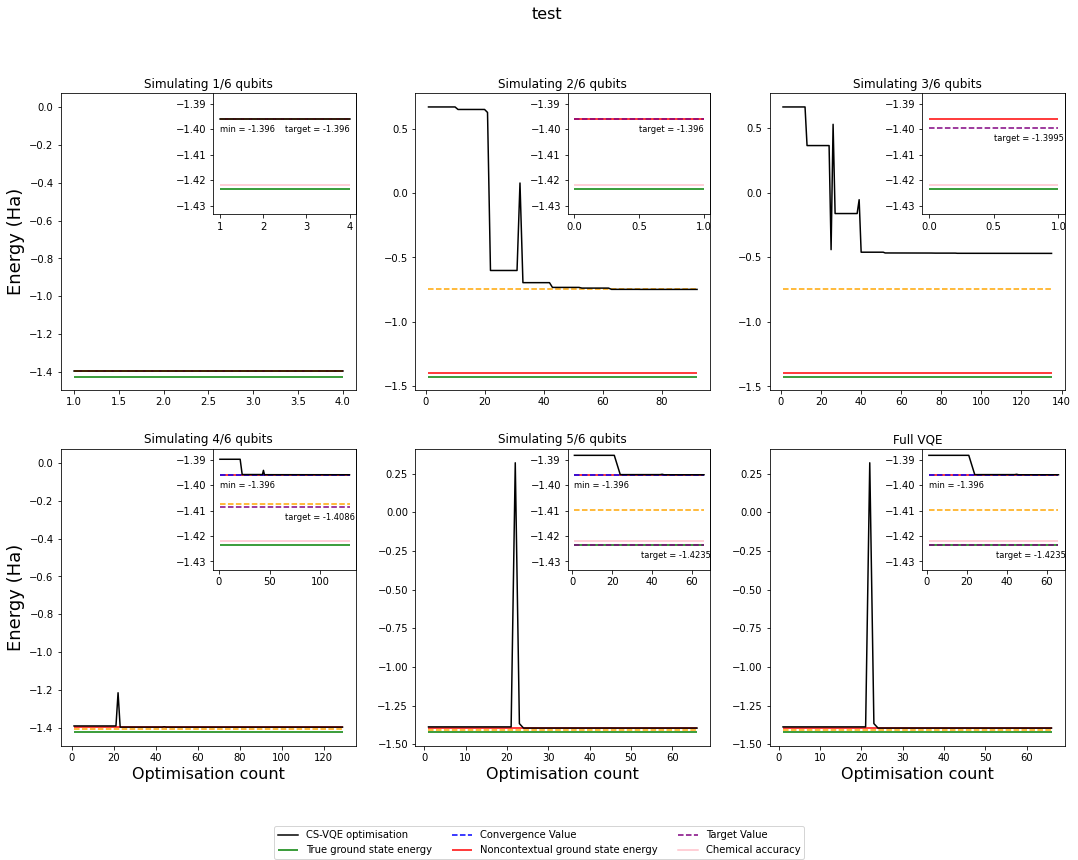

In [25]:
fig = plot.plot_cs_vqe_convergence(data=cs_vqe_results, title='test')

In [8]:
cs_vqe_results

{'rows': 2,
 'cols': 3,
 'grid_pos': [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)],
 'gs_noncon_energy': -1.3959517663812582,
 'true_gs': -1.4234634072414618,
 'num_qubits': 6,
 (0, 0): {'num_sim_q': 1,
  'result': -1.3959517663812584,
  'target': -1.3959517663812586,
  'projected_target': -1.3959517663812582,
  'A_expct': 1.0000000000000004,
  'counts': [1, 2, 3, 4],
  'values': [-1.3959517663812584,
   -1.3959517663812575,
   -1.3959517663812584,
   -1.3959517663812577]},
 (0, 1): {'num_sim_q': 2,
  'result': -0.7475737459570219,
  'target': -1.3959517663812584,
  'projected_target': -0.747573914025403,
  'A_expct': 0.9999999999999987,
  'counts': [1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,


In [9]:
#import json 

#data={}
#for k in cs_vqe_results.keys():
#    data[str(k)] = cs_vqe_results[k]
     
#with open("data/HeH+_3-21g_singlet_UCCSD_CS-VQE_convergence_with_ground_state_projection_and_A_expct.json", "w") as outfile: 
#    json.dump(data, outfile)

In [10]:
circs.order

[3, 0, 4, 1, 5, 2]

In [11]:
mol = c.cs_vqe(hamiltonian, terms_noncon, num_qubits)
generators = list((mol.generators()[0]).keys())
initial_state = mol.init_state()
results={}
shots=10
c_order = [0,1,2,3,4,5]

eig_proj = la.eigenstate_projector(A, num_qubits)
nan_check = []

for index in range(num_qubits):
    removed_index = c_order[0:index]#list(range(index))
    removed_index.reverse()
    removed_generators = [generators[i] for i in removed_index]
    Z_indices = [g.find('Z') for g in removed_generators]
    print(removed_generators, Z_indices)
    nc_proj = la.noncon_projector(initial_state, Z_indices, num_qubits)

    new_ham_noncon, new_ham_context = mol.move_generator(removed_generators)
    new_ham_noncon_q = qonvert.dict_to_QubitOperator(new_ham_noncon)
    new_ham_context_q = qonvert.dict_to_QubitOperator(new_ham_context)

    results[index] = {}
    results[index]['exact'] = get_ground_state(get_sparse_operator(new_ham_noncon_q, num_qubits).toarray())[0]

    expectations = []
    for r in range(shots):
        rand_vec = la.random_complex_vector(2**num_qubits)
        psi = la.apply_projections(rand_vec, [nc_proj, eig_proj])
        expect_noncon = la.expectation(new_ham_noncon_q, psi, num_qubits)
        expectations.append(expect_noncon)
    #print(expectations)
    nc_value = (sum(expectations)/shots).real
    results[index]['+1eig'] = nc_value
    nan_check.append(nc_value)

results

[] []
['ZIIIII'] [0]
['IZIIII', 'ZIIIII'] [1, 0]
['IIZIII', 'IZIIII', 'ZIIIII'] [2, 1, 0]
['IIIIZI', 'IIZIII', 'IZIIII', 'ZIIIII'] [4, 2, 1, 0]
['IIIIIZ', 'IIIIZI', 'IIZIII', 'IZIIII', 'ZIIIII'] [5, 4, 2, 1, 0]


{0: {'exact': -1.3959517663812582, '+1eig': -1.395951766381258},
 1: {'exact': -1.07176284020333, '+1eig': -0.03953464530856786},
 2: {'exact': -0.5657798983657172, '+1eig': -0.5195594593961855},
 3: {'exact': -0.5417768501684467, '+1eig': -0.17797602161250003},
 4: {'exact': -0.3162577739405519, '+1eig': -0.2671006331486197},
 5: {'exact': -0.08709106278163711, '+1eig': -0.026708425025848137}}

[(-1.3959517663812582, -1.07176284020333, -0.5657798983657172, -0.5417768501684467, -0.3162577739405519, -0.08709106278163711), (-1.395951766381258, -0.03953464530856786, -0.5195594593961855, -0.17797602161250003, -0.2671006331486197, -0.026708425025848137)]


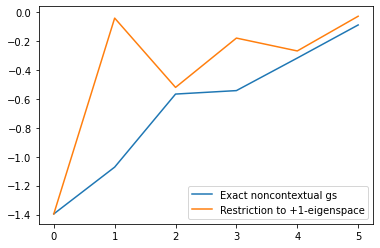

In [12]:
X=range(num_qubits)
values = list(zip(*[list(results[i].values()) for i in X]))
print(values)
Y1=values[0]
Y2=values[1]
#axs[grid].set_title(str(h))
plt.plot(X, Y1, label='Exact noncontextual gs')
plt.plot(X, Y2, label='Restriction to +1-eigenspace')
plt.legend()

In [13]:
#fig.savefig("plots/HeH+-CS-VQE-uccsd_ansatz.png", dpi=300)

/home/tim/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1268: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)
/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


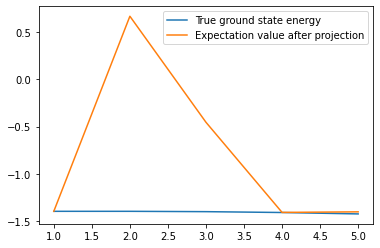

In [14]:
circs.ancilla = False
X = list(range(1, 6))
Y_true = []
Y_proj = []
A = circs.A

for n_q in X:
    ham_red = circs.ham_reduced[n_q-1]
    ham_red_q = qonvert.dict_to_QubitOperator(ham_red)
    gs_red = get_ground_state(get_sparse_operator(ham_red_q, n_q).toarray())
    Y_true.append(gs_red[0])
    
    A_red = circs.reduce_anz_terms(A, n_q)
    eig_proj = la.eigenstate_projector(A_red, n_q)
    psi = gs_red[1]
    psi_proj = la.apply_projections(psi, [eig_proj])
    gs_proj = la.expectation(ham_red, psi_proj, n_q)
    Y_proj.append(gs_proj)
    
plt.plot(X, Y_true, label = 'True ground state energy')
plt.plot(X, Y_proj, label = 'Expectation value after projection')
plt.legend()

In [15]:
rots = circs.all_rotations
print(rots)
rots.reverse()
c_tools.rotate_operator(rots, A)

[['pi/2', 'YIIIII'], ['pi/2', 'YZIIII'], ['pi/2', 'IYIIII'], ['pi/2', 'IYIZII'], ['pi/2', 'IIYIII'], ['pi/2', 'IIYZII']]


{'YXXYII': -1.7228858401222778e-08, 'ZIIIII': -0.9999999999999999}

In [16]:
circs.G

{'ZIIIII': -1.0, 'IZIIII': -1.0, 'IIZIII': 1.0, 'IIIIZI': 1.0, 'IIIIIZ': 1.0}

In [17]:
P1, P2 = A.keys()
r1 = A[P1]
r2 = A[P2]
rot = c_tools.pauli_mult(P1, P2)
t = np.arctan(r1/r2)
single_A = c_tools.rotate_operator([[t*(rot[1]*1j).real, rot[0]]], A)

In [18]:
Z_indices = [g.find('Z') for g in circs.G]

In [19]:
single_A_indices = [i for i, p in enumerate(list(single_A.keys())[0]) if p == 'Z']

In [20]:
ind_Z = [i for i in single_A_indices if i not in Z_indices]

In [21]:
ind_Z

[3]

In [22]:
diag_A = []
for i in ind_Z:    
    blank_op = ['I' for i in range(num_qubits)]
    blank_op[i] = 'Y'
    rot = ''.join(blank_op)
    diag_A.append(['pi/2', rot])
    rotated = c_tools.pauli_mult(rot, list(single_A.keys())[0])[0]
    print(rotated)
    blank_op = ['I' for i in range(num_qubits)]
    for j in single_A_indices:
        if rotated[j]=='Z':
            blank_op[j] = 'Z'
        elif rotated[j] == 'X':
            blank_op[j] = 'Y'
    rot = ''.join(blank_op)
    diag_A.append(['pi/2', rot])

ZZIXII


In [23]:
c_tools.pauli_mult(rot_G, list(single_A.keys())[0])

NameError: name 'rot_G' is not defined

In [ ]:
c_tools.rotate_operator(diag_A, A)

In [ ]:
diag_A

In [ ]:
circs.reference_state(hamiltonian)

In [ ]:
circs.qubit_map(3).keys()